In [1]:
# GET PARAMETERS
import os 
import sys
import pandas as pd
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

print('Current working directory: ',os.getcwd())

Current working directory:  /home/rrochas/prediction-validation


In [2]:
metrics = ['mae','rmse','mape','mase']
for model_name in ['STGCN','STAEformer']:
    for metric in metrics:
        globals()[f"{model_name}_{metric}_list"] = []

percentage_list = [10,15,25,35,50,75,100]
for model_name in ['STGCN','STAEformer']:
    # build list of metrics for each percentage
    for p in percentage_list:
        folder_path = os.path.join(f'save/K_fold_validation/training_wo_HP_tuning/comparison_accuracy_per_size_{model_name}',f'PeMS08_flow_{p}p')
        results = pd.read_csv(f'{folder_path}/METRICS_PeMS08_flow_{p}p.csv',index_col = 0)
        for metric in metrics:
            selected_columns = [c for c in results.columns if (c.startswith(metric)) and not 'complete' in c]
            metric_all = results[selected_columns].mean(axis=1)['test']
            globals()[f"{model_name}_{metric}_list"].append(metric_all)
    # ...
    
    globals()[f"df_{model_name}"] = pd.DataFrame({metric: globals()[f"{model_name}_{metric}_list"] for metric in metrics})


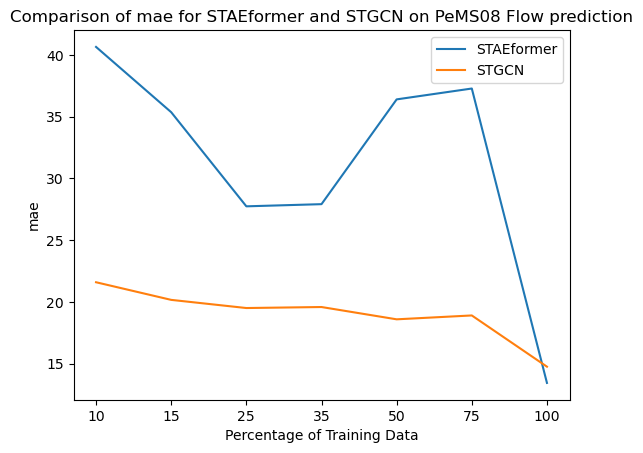

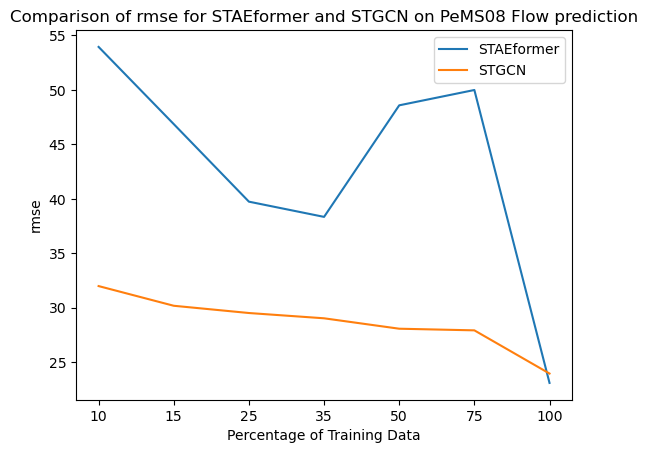

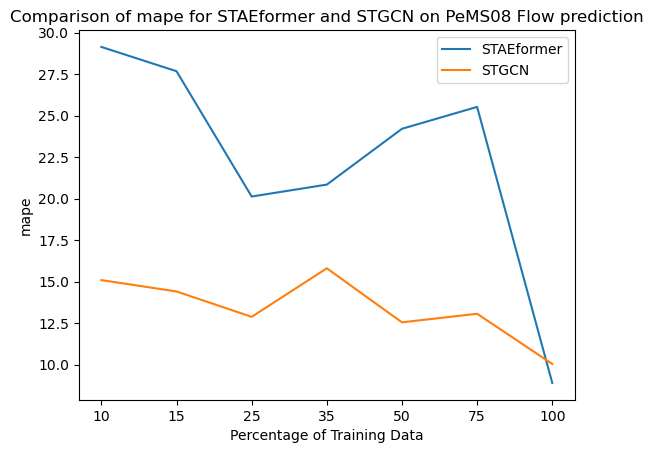

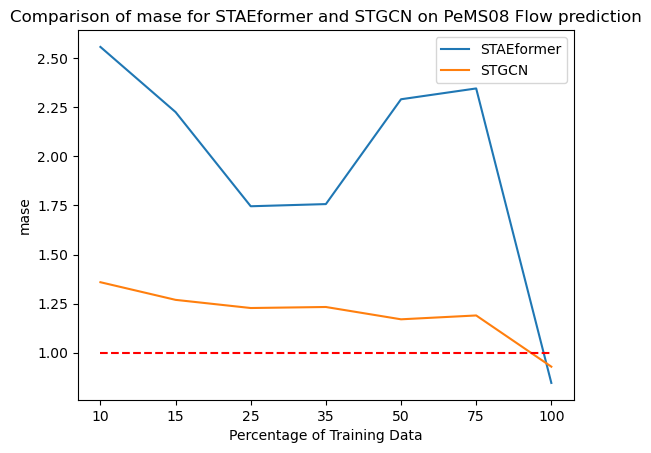

In [3]:
import matplotlib.pyplot as plt
for metric in metrics: 
    fig, ax = plt.subplots(1, 1)
    df_STAEformer[metric].plot()
    df_STGCN[metric].plot()
    plt.title(f'Comparison of {metric} for STAEformer and STGCN on PeMS08 Flow prediction')
    plt.xticks(range(len(percentage_list)), percentage_list)
    plt.ylabel(metric)
    plt.xlabel('Percentage of Training Data')
    plt.legend(['STAEformer', 'STGCN'])
    if metric == 'mase':
        ax.plot([0, len(percentage_list)-1], [1, 1], color='red', linestyle='--', label='MASE = 1')
    plt.show()